In [33]:
try:
    %load_ext autoreload
    %autoreload 2
    %reload_ext autoreload
    %matplotlib inline
    
except:
    print 'NOT IPYTHON'
    
import sys
import numpy as np
import scipy.io as sio
import ca_source_extraction as cse

from ca_source_extraction.initialization import initialize_components,arpfit
from ca_source_extraction.spatial import update_spatial_components
from ca_source_extraction.temporal import update_temporal_components
from ca_source_extraction.merging import mergeROIS
from ca_source_extraction.pre_processing import preprocess_data
from ca_source_extraction.utilities import local_correlations,plot_contours,view_patches,order_components,extract_DF_F

from matplotlib import pyplot as plt
from time import time,sleep
import pylab as pl
from scipy.sparse import coo_matrix,spdiags
import scipy
from sklearn.decomposition import NMF

print 'imported'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
imported



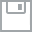
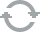
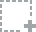
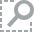
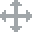
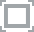
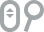
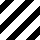
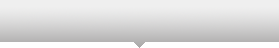
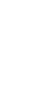
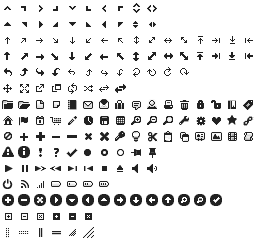
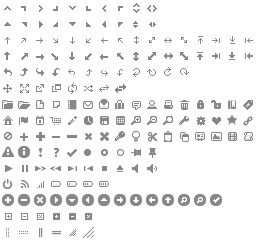
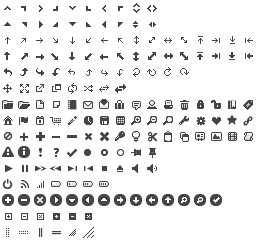
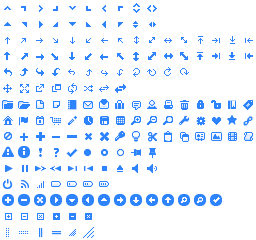
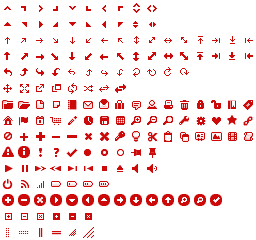
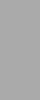
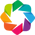
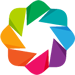

In [5]:
#import bokeh.plotting as bp
import bokeh.plotting as bpl
from bokeh.io import vform,hplot,vplot,gridplot
from bokeh.models import CustomJS, ColumnDataSource, Slider
from IPython.display import display, clear_output
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np

bpl.output_notebook()

In [13]:
deconv_type='debug'
#deconv_type='spgl1'

In [14]:
# LOAD MOVIE AND MAKE DIMENSIONS COMPATIBLE WITH CNMF
import tifffile
t = tifffile.TiffFile('movies/demoMovie.tif') 
Y = t.asarray() 
Y = np.transpose(Y,(1,2,0))*1.
d1,d2,T=Y.shape
print 'done'

done


In [15]:
#%% PREPROCESS DATA
Yr = np.reshape(Y,(d1*d2,T),order='F')
Yr,sn,g=preprocess_data(Yr)
Y=np.reshape(Yr,(d1,d2,T),order='F')
print 'done'

done


In [16]:
#%% INITIALIZE ALGORITHM INPUT
nr = 30 # number of expected neurons
gSig=[4,4] #
gSiz=[9,9] #
ssub=1 # space subsampling
tsub=1 # time subsampling

t1 = time()
Ain, Cin, b_in, f_in, center=initialize_components(Y, K=nr, gSig=gSig, gSiz=gSiz, ssub=ssub, tsub=tsub, nIter = 5, use_median = False, kernel = None)                                                    
print time() - t1 # 
clear_output(wait=True)
print('DONE!')

DONE!


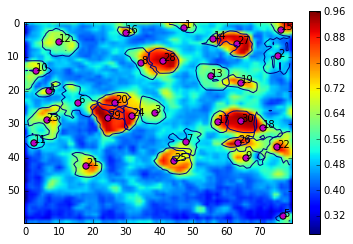

In [17]:
Cn = local_correlations(Y)
plt2 = plt.imshow(Cn,interpolation='none')
plt.colorbar()
plt.scatter(x=center[:,1], y=center[:,0], c='m', s=40)
crd = plot_contours(coo_matrix(Ain[:,::-1]),Cn,thr=0.9)
plt.axis((-0.5,d2-0.5,-0.5,d1-0.5))
plt.gca().invert_yaxis()

In [18]:
colormap =cm.get_cmap("jet") #choose any matplotlib colormap here
grayp = [mpl.colors.rgb2hex(m) for m in colormap(np.arange(colormap.N))]
p = bpl.figure(x_range=[0,Cn.shape[1]], y_range=[0,Cn.shape[0]])
p.image(image=[Cn], x=0, y=0, dw=Cn.shape[1], dh=Cn.shape[0], palette=grayp)
p.circle(center[:,1],center[:,0], size=10, color="black", fill_color=None, line_width=2, alpha=1)
bpl.show(p)

In [20]:
t1 = time()
A,b,Cin = update_spatial_components(Yr, Cin, f_in, Ain, d1=d1, d2=d2, sn = sn,dist=2,max_size=8,min_size=3,n_processes=1)
t_elSPATIAL = time() - t1
print t_elSPATIAL# 
clear_output(wait=True)
print('DONE!')

DONE!


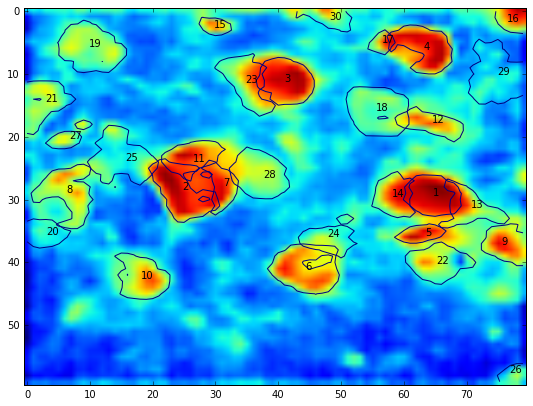

In [22]:
plt.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
crd = plot_contours(A,Cn,thr=0.9)

In [28]:
t1 = time()
C,f,Y_res,Pnew,S = update_temporal_components(Yr,A,b,Cin,f_in,ITER=2,deconv_method = deconv_type)
t_elTEMPORAL2 = time() - t1
print t_elTEMPORAL2 # took 98 sec

clear_output(wait=True)
print('DONE!')

DONE!


In [29]:
t1 = time()
A_sp=A.tocsc();
A_m,C_m,nr_m,merged_ROIs,P_m,S_m=mergeROIS(Y_res,A_sp,b,np.array(C),f,S,d1,d2,Pnew,sn=sn,thr=.85,deconv_method=deconv_type,min_size=3,max_size=8,dist=2)
t_elMERGE = time() - t1
print t_elMERGE

clear_output(wait=True)
print('DONE!')

DONE!


In [30]:
#%%
t1 = time()
A2,b2,C_m_ = update_spatial_components(Yr, C_m, f, A_m, d1=d1, d2=d2, sn = sn,dist=2,max_size=8,min_size=3)
C2,f2,Y_res2,Pnew2,S = update_temporal_components(Yr,A2,b2,C_m_,f,ITER=2,deconv_method = deconv_type)
print time() - t1 # 100 seconds

clear_output(wait=True)
print('DONE!')

DONE!


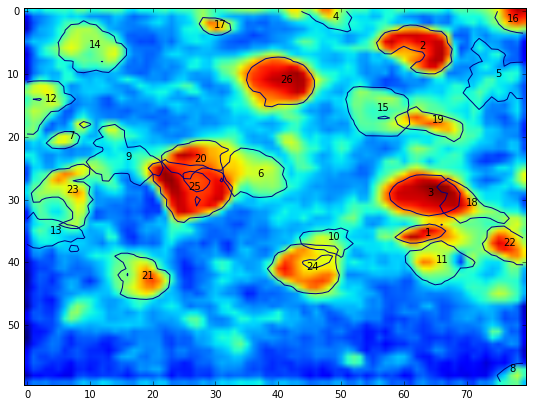

In [31]:
plt.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
A_or, C_or, srt = order_components(A2,C2)
C_df = extract_DF_F(Yr,A2,C2)
crd = plot_contours(coo_matrix(A_or[:,::-1]),Cn,thr=0.9)

In [34]:
nr,T = C_or.shape
nA2 = np.sum(np.array(A_or)**2,axis=0)
Y_r = np.array(spdiags(1/nA2,0,nr,nr)*(A_or.T*np.matrix(Yr-b[:,np.newaxis]*f[np.newaxis])) + C_or)
fig= plt.figure()
coors= plot_contours(coo_matrix(A_or),Cn,thr = 0.9)
plt.close()


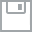
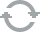
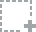
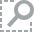
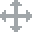
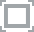
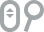
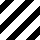
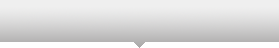
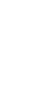
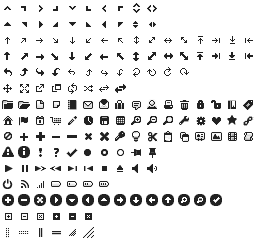
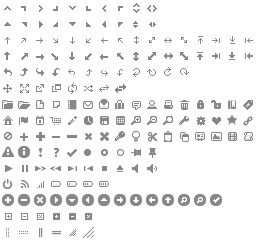
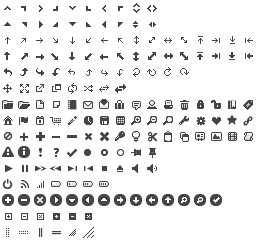
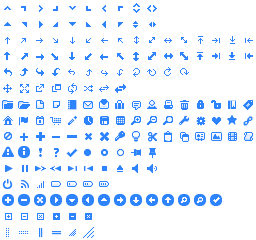
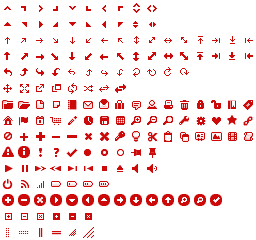
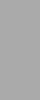
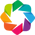
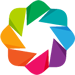

ERROR:/Users/agiovannucci/anaconda/envs/calblitz/lib/python2.7/site-packages/bokeh/validation/check.pyc:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: 2f203b42-8897-4725-aca1-7d971743697a


In [35]:

%matplotlib inline

idneurons=np.arange(d1)
bpl.output_notebook()
x = np.arange(T)
z=np.squeeze(np.array(Y_r[:,:].T))/100
k=np.reshape(np.array(A_or),(d1,d2,A_or.shape[1]),order='F')

cc=coors[0]['coordinates'];
cc1=[cor['coordinates'][:,0] for cor in coors]
cc2=[cor['coordinates'][:,1] for cor in coors]
c1=cc1[0]
c2=cc2[0]
npoints=range(len(c1))

source = ColumnDataSource(data=dict(x=x, y=z[:,0], z=z))

source2 = ColumnDataSource(data=dict(x=npoints,c1=c1,c2=c2,cc1=cc1,cc2=cc2))


plot = bpl.figure(plot_width=600, plot_height=300)
plot.line('x', 'y', source=source, line_width=1, line_alpha=0.6)

callback = CustomJS(args=dict(source=source,source2=source2), code="""
        var data = source.get('data');
        var f = cb_obj.get('value')
        x = data['x']
        y = data['y']
        z = data['z']
        
        for (i = 0; i < x.length; i++) {
            y[i] = z[i][f-1]             
        }
        
        var data2 = source2.get('data');
        c1 = data2['c1'];
        c2 = data2['c2'];
        cc1 = data2['cc1'];
        cc2 = data2['cc2'];
        
        for (i = 0; i < c1.length; i++) {            
               c1[i] = cc1[f][i]
               c2[i] = cc2[f][i]            
        }
        source2.trigger('change');
        source.trigger('change');
        
    """)


slider = Slider(start=1, end=Y_r.shape[0], value=1, step=1, title="Neuron Number", callback=callback)

plot1 = bpl.figure(x_range=[0, d2], y_range=[0, d1],plot_width=300, plot_height=300)
plot1.image(image=[np.sum(k,axis=2)], x=0, y=0, dw=d2, dh=d1, palette=grayp)
plot1.patch('c1','c2',alpha=0.6, color='red',line_width=2,source=source2)

layout = vform(slider, hplot(plot1,plot))

bpl.show(layout)
